# Homogeneous pairs model


In [233]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys, os
sys.path.append('../cmc')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [234]:
import numpy as np   
import pandas as pd
import pdb
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import sys

In [235]:
from utils import *     # contains some useful helper functions 
from models import *    # toy models
from solvers import *   # matrix completion solvers

## Note
In all the implementations, we will assume row represents the users and column represents the movies. This is a nontrivial asumption that will affect the sampling process.

In [236]:
class PairSampling():
    """ 
    This class implements functions to sample observed index set and perform data
    splitting 
    """
    def __init__(self, m, n):
        self.m = m   # shape of the output matrix
        self.n = n
        self.shape = (self.m, self.n)
        
    def sample_submask(self, sub_size, mask=None, w=None, random_state=0):
        np.random.seed(random_state)
        
        if mask is None:
            mask = np.ones(self.shape)
        mask = mask.flatten(order='C')   # flatten the matrix by rows
        obs_idx = np.where(mask == 1)[0]
        sub_size = int(np.clip(sub_size, 1,len(obs_idx)-1))

        if w is not None:
            w = w.flatten(order='C')  # flatten the matrix by rows    
        else:
            w = np.array([1] * (self.m * self.n)) / (self.m * self.n)
        
        # Make sure the weights sum up to 1 at selected indexes
        w = w / np.sum(w[obs_idx])
        sub_idx = np.random.choice(obs_idx, sub_size, replace=False, p=w[obs_idx])

        sub_mask = np.zeros(self.m * self.n)
        sub_mask[sub_idx] = 1
        return sub_mask.reshape(self.shape)
    
    def sample_train_calib(self, mask_obs, n_pairs, random_state=0):
        np.random.seed(random_state)
        
        mask_drop = np.zeros_like(mask_obs)
        mask_train = np.zeros_like(mask_obs)
        mask_calib = np.zeros_like(mask_obs)
        n_obs = np.sum(mask_obs, axis=1)   # Check the observation# in each row
        
        assert n_pairs <= np.sum(n_obs // 2), "Too many calibration pairs and not enough observations!"
        idxs_calib = (-np.ones(2 * n_pairs, dtype=int),\
                      -np.ones(2 * n_pairs, dtype=int))
        
        shuffled_pool = {}
        for i in range(self.m):
            if n_obs[i] > 0:
                idxs = np.where(mask_obs[i]==1)[0]
                np.random.shuffle(idxs)
                if n_obs[i] % 2 != 0:
                    # If the row length is odd, take the last shuffled index as the dropout
                    mask_drop[i][idxs[-1]] = 1
                    idxs = idxs[:-1]
                if len(idxs) > 0:
                    shuffled_pool[i] = idxs
                    
        
        # Sample calibration pairs
        for i in range(n_pairs):
            row = np.random.choice(list(shuffled_pool.keys()))  # Randomly select a row
            
            # First two shuffled entries form a pair
            idxs_calib[0][2 * i], idxs_calib[0][2 * i + 1] = row, row
            idxs_calib[1][2 * i], idxs_calib[1][2 * i + 1] = shuffled_pool[row][0], shuffled_pool[row][1]
            
            # Update the shuffled pool by removing the selected pair
            if len(shuffled_pool[row]) == 2:
                del shuffled_pool[row]
            else:
                shuffled_pool[row] = shuffled_pool[row][2:]
                
        # Get the training mask
        mask_calib[idxs_calib] = 1
        mask_train = mask_obs - mask_calib
        return mask_train, mask_calib, mask_drop, idxs_calib
                

In [237]:
m, n = 310, 300
r = 8
prob_obs = 0.2
random_state = 20

In [238]:
sampler = PairSampling(m,n)
size_obs = m * n * prob_obs
n_calib_pairs = int(size_obs//4)

In [239]:
mask_obs = sampler.sample_submask(size_obs, random_state=random_state)
mask_test = np.ones_like(mask_obs) - mask_obs

In [240]:
mask_train, mask_calib, mask_drop, idxs_calib = sampler.sample_train_calib(mask_obs, n_calib_pairs,
                                                                           random_state=random_state)

In [241]:
RFM = RandomFactorizationModel(m ,n, r)
U, V, M = RFM.sample_noiseless(random_state)

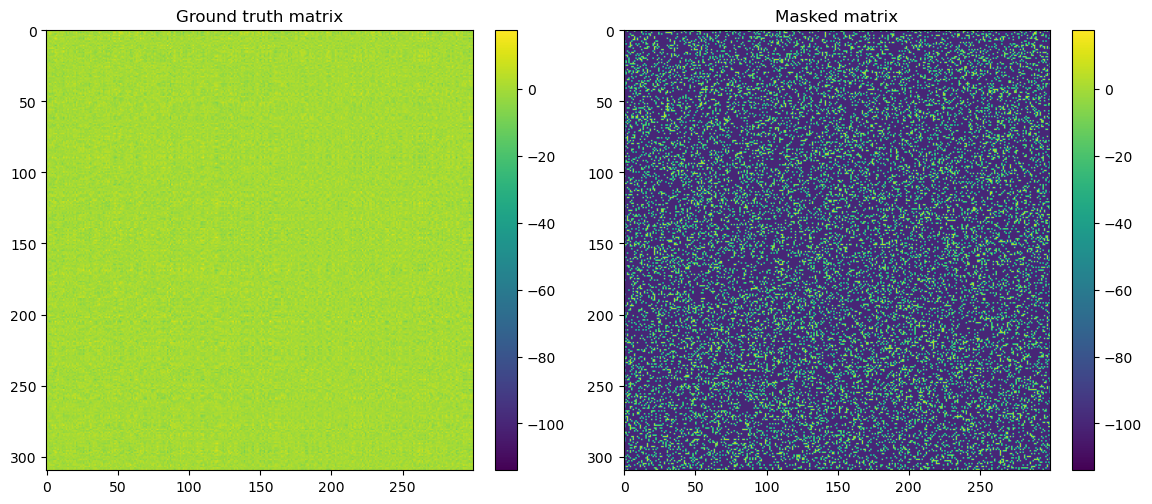

Observation size: 18600.0, training size: 9300.0, calib size: 9300.0, calib pairs: 4650


In [242]:
assert np.all(mask_train+mask_calib==mask_obs),'Sampling error!'
vmin, vmax = np.min(M)-100, np.max(M)
plot_before_after_mask(M, mask_obs, vmin, vmax)
print("Observation size: {}, training size: {}, calib size: {}, calib pairs: {}"
      .format(np.sum(mask_obs), np.sum(mask_train), np.sum(mask_calib), n_calib_pairs))

In [243]:
print("Weighted sampling\n"+"-"*25)
print('Solving matrix completion with PMF...')
Mhat, Uhat, Vhat = pmf_solve(M, mask_train, k=r, random_state=random_state, verbose=True)
test_mse = evaluate_mse(M, Mhat, mask_test)
train_mse = evaluate_mse(M, Mhat, mask_train)
calib_mse = evaluate_mse(M, Mhat, mask_calib)
print('train MSE: {}, calib MSE: {}, test MSE: {}'
      .format(train_mse, calib_mse, test_mse))

Weighted sampling
-------------------------
Solving matrix completion with PMF...
Iteration: 1; Mean diff: 0.0007
Iteration: 2; Mean diff: 0.0000
Iteration: 3; Mean diff: 0.0000
Iteration: 4; Mean diff: 0.0000
Iteration: 5; Mean diff: 0.0000
Iteration: 6; Mean diff: 0.0000
Stopping criteria met, training terminated.
train MSE: 3.858014579199995e-06, calib MSE: 0.06740215487002724, test MSE: 0.05243863016021043


In [244]:
# Sample test pairs
n_test_pairs = min(int((np.sum(mask_test)-m)//2), 1000)
_, _, _, idxs_test = sampler.sample_train_calib(mask_test, n_test_pairs, random_state=random_state)

In [245]:
def falling(n, k):
    res = 1
    for i in range(k):
        res /= n - 2*(i+1) + 1
    return res

def log_falling(log_base, n, k):
    res = 0
    for i in range(k):
        res -= np.emath.logn(log_base, n - 2*(i+1) + 1)
    return res

class PairedCI_hpm():
    """ 
    Conformalized CI for pairs generated with the homogeneous pairs model.
    """
    def __init__(self, M, Mhat, mask_obs, mask_train, idxs_calib, 
                 verbose=True, progress=True):
        self.n1, self.n2 = M.shape[0], M.shape[1]
        self.Mhat = Mhat
        self.verbose = verbose
        self.progress = progress
        self.mask_obs = mask_obs
        
        # Number of observations for each user
        self.n_obs = np.sum(mask_obs, axis=1)
        # Number of observations for each user after random dropping
        self.n_obs_drop = self.n_obs - self.n_obs % 2
        
        # Note that calib indexs should be a tuple
        # idxs_calib[0] is an array of user indexes
        # idxs_calib[1] is an array of movie indexes
        # Two consecutive locations form a pair
        self.idxs_calib = idxs_calib
        self.n_calib_pairs = len(idxs_calib[0])//2
        self.calib_scores = np.zeros(self.n_calib_pairs)
        
        self.residuals = np.abs(M - self.Mhat)
        
        # Compute the calibration scores
        self._get_calib_scores()
        self.calib_order = np.argsort(self.calib_scores)
        self.st_calib_scores = self.calib_scores[self.calib_order]
    
    # This function implements the scores as the absolute residuals
    def _get_calib_scores(self):
        for i in range(self.n_calib_pairs):
            score1 = self.residuals[self.idxs_calib[0][2 * i]][self.idxs_calib[1][2 * i]]
            score2 = self.residuals[self.idxs_calib[0][2 * i + 1]][self.idxs_calib[1][2 * i + 1]]
            self.calib_scores[i] = np.max([score1, score2])
    
    
    def _initial_prob(self, log_base):
        # Users in the calibration pairs
        users_calib = np.zeros(self.n_calib_pairs, dtype = int)
        # Number of calibration paris for each user
        n_pairs = np.zeros(self.n1, dtype = int)
        
        for i in range(self.n_calib_pairs):
            user = self.idxs_calib[0][2 * i]
            users_calib[i] = user
            n_pairs[user] += 1
                
#         prob_calib = 1
#         for i,k in enumerate(n_pairs):
#             prob_calib *= falling(self.n_obs_drop[i], k)
#         prob_drop = np.prod(1 / self.n_obs[(self.n_obs % 2) != 0])
#         prob_calib = 0
#         for i,k in enumerate(n_pairs):
#             prob_calib += log_falling(log_base, self.n_obs_drop[i], k)
#         prob_drop = np.sum(-np.emath.logn(log_base, self.n_obs[(self.n_obs % 2) != 0]))
#         return prob_drop * prob_calib, users_calib, n_pairs
        
        #assert abs(prob_drop + prob_calib) != float('inf'), "Overflow occured, try a large log base value."       
        #return prob_drop + prob_calib, users_calib, n_pairs
        return 1, users_calib, n_pairs
    
    def _weight_single(self, user_test, initial_w, users_calib, n_pairs, log_base):
        # Initial weights
        #weights = np.array([initial_w] * (self.n_calib_pairs + 1))
        weights = np.ones(self.n_calib_pairs + 1)
        
        # Compute the calibration weights
        for i in range(self.n_calib_pairs):
            user_calib = users_calib[i]
            if user_calib == user_test:
                prob_test = 1 / (self.n2 - self.n_obs[user_calib] - 1)
                prob_drop = 1
                prob_calib = 1
            else:                
                prob_test = 1 / (self.n2 - self.n_obs[user_calib] - 3)
                prob_drop = (1 + 2 / (self.n_obs[user_calib] - 2)) ** (self.n_obs[user_calib] % 2 == 1)
                prob_drop *= (1 - 2 / (self.n_obs[user_test] + 2)) ** (self.n_obs[user_test] % 2 == 1)
                prob_calib = (self.n_obs_drop[user_calib]-1) / (self.n_obs_drop[user_test]+1)
            weights[i] *= prob_test * prob_drop * prob_calib
            
#             if prob_calib > 5 or prob_calib < 0.2:
#                 pdb.set_trace()
                
            #weights[i] += np.sum(np.emath.logn(log_base,[prob_test, prob_drop, prob_calib]))
        # Compute the test weight
        weights[-1] *= 1 / (self.n2 - self.n_obs[user_test] - 1)
        #weights[-1] += np.emath.logn(log_base, 1 / (self.n2 - self.n_obs[user_test] - 1))
        
        #ln0 = np.max(weights)
        #weights = np.power(log_base, weights-ln0)
        #assert np.all(weights > 0), "Overflow occured, try a large log base value."
        weights /= np.sum(weights)
        
        return weights[:-1]
            

    def get_CI(self, idxs_test, alpha, allow_inf=True, log_base = "auto"):
        n_test_pairs = len(idxs_test[0])//2
        weights_list = [[]]*n_test_pairs
        
        upper = np.zeros(n_test_pairs * 2)    # upper confidence bound
        lower = np.zeros(n_test_pairs * 2)    # lower confidence bound
        is_inf = np.zeros(n_test_pairs) # positions where interval length is infinity   
        
        if self.verbose:
            print("Computing prediction intervals for {} test pairs...".format(n_test_pairs))
            sys.stdout.flush()
        
        if log_base == "auto":
            log_base = self.n1 
        initial_w, users_calib, n_pairs = self._initial_prob(log_base) 
        
        for i in tqdm(range(n_test_pairs), desc="CI", leave=True, position=0, 
                      disable = not self.progress):
            idx_test = (idxs_test[0][2*i : 2*(i+1)], idxs_test[1][2*i : 2*(i+1)])
            user_test = idx_test[0][0]
      
            weights = self._weight_single(user_test, initial_w, users_calib, n_pairs, log_base)
            weights_list[i] = weights
            cweights = np.cumsum(weights[self.calib_order])
            
            qnt = np.quantile(self.calib_scores, 1 - alpha, method="lower")
            est = self.Mhat[idx_test]
                        
            # Note that absolute residual scores lead to PI pair with the same length
            if cweights[-1] < 1-alpha:
                is_inf[i] = 1
                if allow_inf:
                    lower[2*i], lower[2*i + 1] = -np.inf, -np.inf
                    upper[2*i], upper[2*i + 1] = np.inf, np.inf
                else:
                    lower[2*i], lower[2*i + 1] = est[0] - self.st_calib_scores[-1], est[1] - self.st_calib_scores[-1]
                    upper[2*i], upper[2*i + 1] = est[0] + self.st_calib_scores[-1], est[1] + self.st_calib_scores[-1]
            else:
                idx = np.argmax(cweights >= 1-alpha)
                lower[2*i], lower[2*i + 1] = est[0] - self.st_calib_scores[idx], est[1] - self.st_calib_scores[idx]
                upper[2*i], upper[2*i + 1] = est[0] + self.st_calib_scores[idx], est[1] + self.st_calib_scores[idx]
        
        if self.verbose:
            print("Done!")
            sys.stdout.flush()
            
        #--- [DEBUG]for deubugging purpose, also return the weights ---#
        # return the confidence interval in the matrix format
        return lower, upper, is_inf, weights_list
        
    def naive_CI(self, idxs_test, alpha):
        n_test_pairs = len(idxs_test[0])//2
        if self.verbose:
            print("Computing naive prediction intervals for {} test pairs...".format(n_test_pairs))
            sys.stdout.flush()

        est = self.Mhat[idxs_test]
        qnt = np.quantile(self.calib_scores, 1 - alpha, method="lower")
        lower, upper = est - qnt, est + qnt   

        if self.verbose:
            print("Done!")
            sys.stdout.flush()
        return lower, upper

def benchmark_CI(M, Mhat, idxs_calib, idxs_test, alpha, verbose = True):
    n_test_pairs = len(idxs_test[0])//2
    alpha_corrected = alpha / 2
    
    if verbose:
        print("Computing prediction intervals for {} test pairs...".format(n_test_pairs))
        sys.stdout.flush()

    residuals = np.abs(M - Mhat)
    residual_calib = residuals[idxs_calib]

    est = Mhat[idxs_test]
    qnt = np.quantile(residual_calib, 1 - alpha_corrected, method="lower")
    lower, upper = est - qnt, est + qnt   
    
    if verbose:
        print("Done!")
        sys.stdout.flush()
        
    return lower, upper


In [246]:
alpha = 0.1
cpi = PairedCI_hpm(M, Mhat, mask_obs, mask_train, idxs_calib)

In [247]:
cpi_lower, cpi_upper, is_inf, weights = cpi.get_CI(idxs_test, alpha)

Computing prediction intervals for 1000 test pairs...


CI: 100%|██████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 84.32it/s]

Done!


In [248]:
naive_lower, naive_upper = cpi.naive_CI(idxs_test, alpha)

Computing naive prediction intervals for 1000 test pairs...
Done!


In [286]:
bm_lower, bm_upper = benchmark_CI(M, Mhat, idxs_calib, idxs_test, 2*alpha)

Computing prediction intervals for 1000 test pairs...
Done!


In [250]:
def evaluate_CI(lower, upper, M, idxs_test, label=None):
    label = str(label)+'_' if label else ''
    val = M[idxs_test]
    coverage = np.mean((lower < val) & (upper > val))
    size = np.mean(upper - lower)
    
    results = pd.DataFrame({})
    results[label+"Coverage"] = [coverage]
    results[label+"Size"] = [size]
    return results

def evaluate_pairedCI(lower, upper, M, idxs_test, label=None):
    label = str(label)+'_' if label else ''
    val = M[idxs_test]
    n_test_pair = len(idxs_test[0]) // 2
    
    covered = (lower < val) & (upper > val)
    pair_covered = [covered[2*i] * covered[2*i+1] for i in range(n_test_pair)]
    
    coverage = np.mean(pair_covered)
    size = np.mean(upper - lower)
    results = pd.DataFrame({})
    results[label+"Coverage"] = [coverage]
    results[label+"Size"] = [size]
    return results

In [251]:
evaluate_CI(naive_lower, naive_upper, M, idxs_test, label="Naive" )

,Naive_Coverage,Naive_Size
0,0.946,0.033052


In [252]:
evaluate_CI(cpi_lower, cpi_upper, M, idxs_test, label="CPI" )

,CPI_Coverage,CPI_Size
0,0.936,0.028999


In [287]:
evaluate_CI(bm_lower, bm_upper, M, idxs_test, label="Benchmark" )

,Benchmark_Coverage,Benchmark_Size
0,0.914,13.759963


In [254]:
evaluate_pairedCI(naive_lower, naive_upper, M, idxs_test, label="Naive" )

,Naive_Coverage,Naive_Size
0,0.926,0.033052


In [255]:
evaluate_pairedCI(cpi_lower, cpi_upper, M, idxs_test, label="CPI" )

,CPI_Coverage,CPI_Size
0,0.909,0.028999


In [288]:
evaluate_pairedCI(bm_lower, bm_upper, M, idxs_test, label="Benchmark" )

,Benchmark_Coverage,Benchmark_Size
0,0.839,13.759963


In [275]:
def run_single_experiment(M, alpha, size_obs, r_guess, verbose=True, random_state=0):
    res = pd.DataFrame({})
    pair_res = pd.DataFrame({})
    #-------Generate masks----------#
    sampler = PairSampling(m,n)
    n_calib_pairs = int(size_obs//4)
    mask_train, mask_calib, mask_drop, idxs_calib = sampler.sample_train_calib(mask_obs, n_calib_pairs,random_state=random_state)
    # Sample test pairs
    n_test_pairs = min(int((np.sum(mask_test)-m)//2), 2000)
    _, _, _, idxs_test = sampler.sample_train_calib(mask_test, n_test_pairs, random_state=random_state)    
    print("Training size:{}, calib size: {}, test size: {}".format(np.sum(mask_train), n_calib_pairs, n_test_pairs))
    
    #------Conformal methods---------#
    print("Running matrix completion algorithm on the splitted training set...")
    Mhat, Uhat, Vhat = pmf_solve(M, mask_train, k=r_guess, verbose=False, random_state=random_state)
    print("Done training!")
    
    cpi = PairedCI_hpm(M, Mhat, mask_obs, mask_train, idxs_calib)
    #cpi_lower, cpi_upper, is_inf, weights = cpi.get_CI(idxs_test, alpha)
    naive_lower, naive_upper = cpi.naive_CI(idxs_test, alpha)
    bm_lower, bm_upper = benchmark_CI(M, Mhat, idxs_calib, idxs_test, alpha)
        
    #res = pd.concat([res, evaluate_CI(cpi_lower, cpi_upper, M, idxs_test, label="CPI")], axis=1)
    res = pd.concat([res, evaluate_CI(naive_lower, naive_upper, M, idxs_test, label="Naive")], axis=1)           
    res = pd.concat([res, evaluate_CI(bm_lower, bm_upper, M, idxs_test, label="Benchmark" )], axis=1) 
    
    #pair_res = pd.concat([pair_res,evaluate_pairedCI(cpi_lower, cpi_upper, M, idxs_test, label="CPI")], axis=1)
    pair_res = pd.concat([pair_res,evaluate_pairedCI(naive_lower, naive_upper, M, idxs_test, label="Naive")], axis=1)
    pair_res = pd.concat([pair_res,evaluate_pairedCI(bm_lower, bm_upper, M, idxs_test, label="Benchmark")], axis=1)
    
    pair_res['Alpha'] = [alpha]
    pair_res['Seed'] = [random_state]
    pair_res['Calib_size'] = [n_calib_pairs]
    pair_res['Train_size'] = [np.sum(mask_train)]
    pair_res['Test_size'] = [n_test_pairs]
    
    res['Alpha'] = [alpha]
    res['Seed'] = [random_state]
    res['Calib_size'] = [n_calib_pairs]
    res['Train_size'] = [np.sum(mask_train)]
    res['Test_size'] = [n_test_pairs]
    return res, pair_res

In [276]:
m, n = 310, 300
r = 10
prob_obs = 0.2
size_obs = int(m * n * prob_obs)
alpha = 0.1
repetition = 20

In [277]:
print('Fixing the ground truth matrix generated from the noiseless random orthogonal model.\n')
RFM = RandomFactorizationModel(m ,n, r)
U, V, M = RFM.sample_noiseless(0)

Fixing the ground truth matrix generated from the noiseless random orthogonal model.



In [278]:
results = pd.DataFrame({})
pair_results = pd.DataFrame({})

for i in tqdm(range(repetition), desc="Repetitions", leave=True, position=0):
    random_state = i

    res, pair_res = run_single_experiment(M, alpha, size_obs, r_guess=r, verbose=True, random_state=i)
    
    results = pd.concat([results, res])
    pair_results = pd.concat([pair_results, pair_res])

Repetitions:   0%|                                                                              | 0/20 [00:00<?, ?it/s]

Training size:9300.0, calib size: 4650, test size: 2000
Running matrix completion algorithm on the splitted training set...
Done training!
Computing naive prediction intervals for 2000 test pairs...
Done!
Computing prediction intervals for 2000 test pairs...
Done!


Repetitions:   5%|███▌                                                                  | 1/20 [00:02<00:46,  2.44s/it]

Training size:9300.0, calib size: 4650, test size: 2000
Running matrix completion algorithm on the splitted training set...
Done training!
Computing naive prediction intervals for 2000 test pairs...
Done!
Computing prediction intervals for 2000 test pairs...
Done!


Repetitions:  10%|███████                                                               | 2/20 [00:32<05:38, 18.81s/it]

Training size:9300.0, calib size: 4650, test size: 2000
Running matrix completion algorithm on the splitted training set...
Done training!
Computing naive prediction intervals for 2000 test pairs...
Done!
Computing prediction intervals for 2000 test pairs...
Done!


Repetitions:  15%|██████████▌                                                           | 3/20 [01:05<07:09, 25.25s/it]

Training size:9300.0, calib size: 4650, test size: 2000
Running matrix completion algorithm on the splitted training set...
Done training!
Computing naive prediction intervals for 2000 test pairs...
Done!
Computing prediction intervals for 2000 test pairs...
Done!


Repetitions:  20%|██████████████                                                        | 4/20 [01:42<07:58, 29.90s/it]

Training size:9300.0, calib size: 4650, test size: 2000
Running matrix completion algorithm on the splitted training set...
Done training!
Computing naive prediction intervals for 2000 test pairs...
Done!
Computing prediction intervals for 2000 test pairs...
Done!


Repetitions:  25%|█████████████████▌                                                    | 5/20 [02:30<09:03, 36.25s/it]

Training size:9300.0, calib size: 4650, test size: 2000
Running matrix completion algorithm on the splitted training set...
Done training!
Computing naive prediction intervals for 2000 test pairs...
Done!
Computing prediction intervals for 2000 test pairs...
Done!


Repetitions:  30%|█████████████████████                                                 | 6/20 [03:18<09:25, 40.38s/it]

Training size:9300.0, calib size: 4650, test size: 2000
Running matrix completion algorithm on the splitted training set...
Done training!
Computing naive prediction intervals for 2000 test pairs...
Done!
Computing prediction intervals for 2000 test pairs...
Done!


Repetitions:  35%|████████████████████████▌                                             | 7/20 [04:05<09:12, 42.52s/it]

Training size:9300.0, calib size: 4650, test size: 2000
Running matrix completion algorithm on the splitted training set...
Done training!
Computing naive prediction intervals for 2000 test pairs...
Done!
Computing prediction intervals for 2000 test pairs...
Done!


Repetitions:  40%|████████████████████████████                                          | 8/20 [04:52<08:47, 43.95s/it]

Training size:9300.0, calib size: 4650, test size: 2000
Running matrix completion algorithm on the splitted training set...
Done training!
Computing naive prediction intervals for 2000 test pairs...
Done!
Computing prediction intervals for 2000 test pairs...
Done!


Repetitions:  45%|███████████████████████████████▌                                      | 9/20 [05:38<08:10, 44.63s/it]

Training size:9300.0, calib size: 4650, test size: 2000
Running matrix completion algorithm on the splitted training set...
Done training!
Computing naive prediction intervals for 2000 test pairs...
Done!
Computing prediction intervals for 2000 test pairs...
Done!


Repetitions:  50%|██████████████████████████████████▌                                  | 10/20 [06:24<07:30, 45.03s/it]

Training size:9300.0, calib size: 4650, test size: 2000
Running matrix completion algorithm on the splitted training set...
Done training!
Computing naive prediction intervals for 2000 test pairs...
Done!
Computing prediction intervals for 2000 test pairs...
Done!


Repetitions:  55%|█████████████████████████████████████▉                               | 11/20 [07:10<06:48, 45.42s/it]

Training size:9300.0, calib size: 4650, test size: 2000
Running matrix completion algorithm on the splitted training set...
Done training!
Computing naive prediction intervals for 2000 test pairs...
Done!
Computing prediction intervals for 2000 test pairs...
Done!


Repetitions:  60%|█████████████████████████████████████████▍                           | 12/20 [08:01<06:15, 46.98s/it]

Training size:9300.0, calib size: 4650, test size: 2000
Running matrix completion algorithm on the splitted training set...
Done training!
Computing naive prediction intervals for 2000 test pairs...
Done!
Computing prediction intervals for 2000 test pairs...
Done!


Repetitions:  65%|████████████████████████████████████████████▊                        | 13/20 [08:49<05:31, 47.34s/it]

Training size:9300.0, calib size: 4650, test size: 2000
Running matrix completion algorithm on the splitted training set...
Done training!
Computing naive prediction intervals for 2000 test pairs...
Done!
Computing prediction intervals for 2000 test pairs...
Done!


Repetitions:  70%|████████████████████████████████████████████████▎                    | 14/20 [09:38<04:47, 47.89s/it]

Training size:9300.0, calib size: 4650, test size: 2000
Running matrix completion algorithm on the splitted training set...
Done training!
Computing naive prediction intervals for 2000 test pairs...
Done!
Computing prediction intervals for 2000 test pairs...
Done!


Repetitions:  75%|███████████████████████████████████████████████████▊                 | 15/20 [10:27<04:01, 48.20s/it]

Training size:9300.0, calib size: 4650, test size: 2000
Running matrix completion algorithm on the splitted training set...
Done training!
Computing naive prediction intervals for 2000 test pairs...
Done!
Computing prediction intervals for 2000 test pairs...
Done!


Repetitions:  80%|███████████████████████████████████████████████████████▏             | 16/20 [11:19<03:16, 49.20s/it]

Training size:9300.0, calib size: 4650, test size: 2000
Running matrix completion algorithm on the splitted training set...
Done training!
Computing naive prediction intervals for 2000 test pairs...
Done!
Computing prediction intervals for 2000 test pairs...
Done!


Repetitions:  85%|██████████████████████████████████████████████████████████▋          | 17/20 [12:11<02:30, 50.14s/it]

Training size:9300.0, calib size: 4650, test size: 2000
Running matrix completion algorithm on the splitted training set...
Done training!
Computing naive prediction intervals for 2000 test pairs...
Done!
Computing prediction intervals for 2000 test pairs...
Done!


Repetitions:  90%|██████████████████████████████████████████████████████████████       | 18/20 [12:55<01:36, 48.38s/it]

Training size:9300.0, calib size: 4650, test size: 2000
Running matrix completion algorithm on the splitted training set...
Done training!
Computing naive prediction intervals for 2000 test pairs...
Done!
Computing prediction intervals for 2000 test pairs...
Done!


Repetitions:  95%|█████████████████████████████████████████████████████████████████▌   | 19/20 [13:40<00:47, 47.14s/it]

Training size:9300.0, calib size: 4650, test size: 2000
Running matrix completion algorithm on the splitted training set...
Done training!
Computing naive prediction intervals for 2000 test pairs...
Done!
Computing prediction intervals for 2000 test pairs...
Done!


Repetitions: 100%|█████████████████████████████████████████████████████████████████████| 20/20 [14:23<00:00, 43.20s/it]


Weighted sampling
-------------------------
Test size is 2000, calibration size is 4650, training size is 9300.0


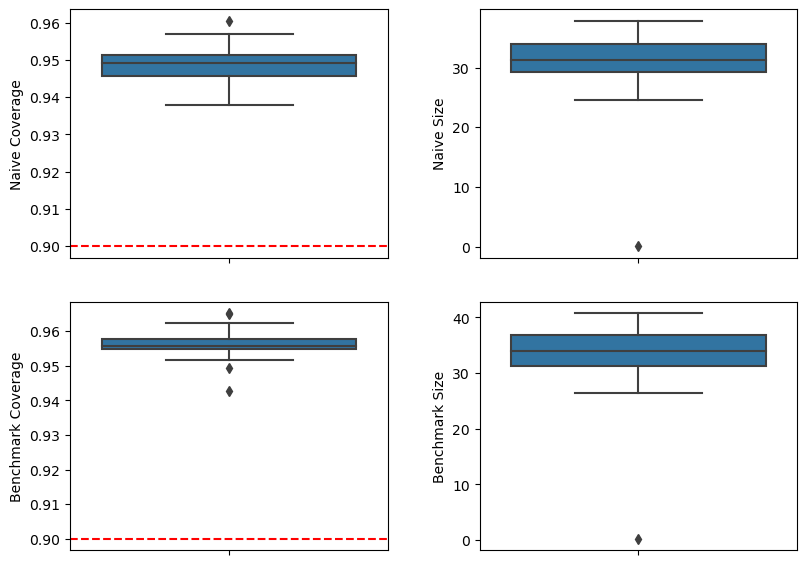

In [284]:
print("Weighted sampling\n"+"-"*25)
print('Test size is {}, calibration size is {}, training size is {}'\
      .format(results['Test_size'].iloc[0], results['Calib_size'].iloc[0], 
              results['Train_size'].iloc[0]))

fig, axs = plt.subplots(2,2, figsize=(8,6))
fig.tight_layout(w_pad=3.5)
# sns.boxplot(y="CPI_Coverage", data=results, ax=axs[0,0])
# axs[0,0].set(ylabel='CPI Coverage')
# axs[0,0].axhline(1-alpha, ls='--', color="red")

# sns.boxplot(y="CPI_Size", data=results, ax=axs[0,1])
# axs[0,1].set(ylabel='CPI Size')

sns.boxplot(y="Naive_Coverage", data=results, ax=axs[0,0])
axs[0,0].set(ylabel='Naive Coverage')
axs[0,0].axhline(1-alpha, ls='--', color="red")

sns.boxplot(y="Naive_Size", data=results, ax=axs[0,1])
axs[0,1].set(ylabel='Naive Size')

sns.boxplot(y="Benchmark_Coverage", data=results, ax=axs[1,0])
axs[1,0].set(ylabel='Benchmark Coverage')
axs[1,0].axhline(1-alpha, ls='--', color="red")

sns.boxplot(y="Benchmark_Size", data=results, ax=axs[1,1])
axs[1,1].set(ylabel='Benchmark Size')

plt.show()

Weighted sampling
-------------------------
Test size is 2000, calibration size is 4650, training size is 9300.0


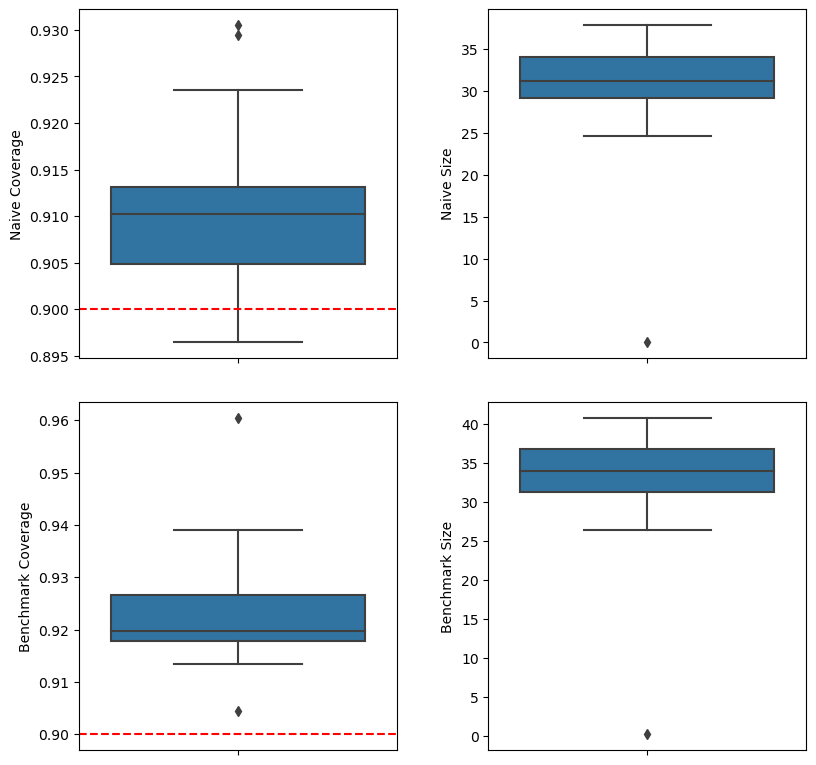

In [285]:
print("Weighted sampling\n"+"-"*25)
print('Test size is {}, calibration size is {}, training size is {}'\
      .format(pair_results['Test_size'].iloc[0], pair_results['Calib_size'].iloc[0], 
              pair_results['Train_size'].iloc[0]))

fig, axs = plt.subplots(2,2, figsize=(8,8))
fig.tight_layout(w_pad=3.5)
# sns.boxplot(y="CPI_Coverage", data=pair_results, ax=axs[0,0])
# axs[0,0].set(ylabel='CPI Coverage')
# axs[0,0].axhline(1-alpha, ls='--', color="red")

# sns.boxplot(y="CPI_Size", data=pair_results, ax=axs[0,1])
# axs[0,1].set(ylabel='CPI Size')

sns.boxplot(y="Naive_Coverage", data=pair_results, ax=axs[0,0])
axs[0,0].set(ylabel='Naive Coverage')
axs[0,0].axhline(1-alpha, ls='--', color="red")

sns.boxplot(y="Naive_Size", data=pair_results, ax=axs[0,1])
axs[0,1].set(ylabel='Naive Size')

sns.boxplot(y="Benchmark_Coverage", data=pair_results, ax=axs[1,0])
axs[1,0].set(ylabel='Benchmark Coverage')
axs[1,0].axhline(1-alpha, ls='--', color="red")

sns.boxplot(y="Benchmark_Size", data=pair_results, ax=axs[1,1])
axs[1,1].set(ylabel='Benchmark Size')

plt.show()

In [266]:
pair_results

,Naive_Coverage,Naive_Size,Benchmark_Coverage,Benchmark_Size,Alpha,Seed,Calib_size,Train_size,Test_size
0,0.931,0.031484,0.9630,0.056555,0.1,0,4650,9300.0,2000
0,0.917,1.517514,0.9265,1.718221,0.1,1,4650,9300.0,2000


In [267]:
results

,Naive_Coverage,Naive_Size,Benchmark_Coverage,Benchmark_Size,Alpha,Seed,Calib_size,Train_size,Test_size
0,0.9495,0.031484,0.96900,0.056555,0.1,0,4650,9300.0,2000
0,0.9500,1.517514,0.95625,1.718221,0.1,1,4650,9300.0,2000


In [281]:
# import os  
# os.makedirs('../results', exist_ok=True)  
# results.to_csv('../results/results.csv')  
# pair_results.to_csv('../results/pair_results.csv')  

In [282]:
results = pd.read_csv('../results/results.csv')  
pair_results = pd.read_csv('../results/pair_results.csv')  